# Computer Assignment 6 a2) -- Group 2
* Ali Bemani
* Oscar Bautista Gonzalez
* Martin Hellkvist

## Problem setup

In this computer assignment, the main aim is to find a hyper-plane W that separates MNIST data linerly in the space where the data resides, with the use of ADMM algorithm. This can be posed as the following optimization problem

Given a dataset $\{(x_i,y_i)\}_{i=1}^I (x_i \in \mathbb{R}^n,y_i \in -1,+1)$ in L2-regulirized.
L2-loss (squared hinge loss) SVM we have
$$ \min_{w} C\sum_{i=1}^I max(0,1-y_iw^Tx_i) $$

Same as CA4, we only use the binary SVM classifier and we ignore multiclass SVM classifier for somplicity.
The task of linear classification is now distributed among various workers, for this each worker will have a different random dataset. Now to make the problem amenable to decomposition, we consider that we have $\{N_1, N_2,\cdots,N_M\}$ as apartition of data with indices $\{1,2,\cdots,I\}$

Now, we can write the SVM in the distributed setting like this
$$ \min_{w} C\sum_{m=1}^M \sum_{i\in [N_m]} max(0,1-y_iw_m^Tx_i)$$

Where M is the number of workers in the network. Now each worker works with it's own dataset and tries to find an optimal $w$ for it's iteration, so we can consider that, there is no single $w$, there is a set of whight vectors which each worker tries to solve it's optimization problem. We represent each of these weight vectors by $w_m$ for $m=1,2,\cdots,M$ workers.
Finally we want to find the global vector $w$ to be a unique vector, so we can limith our optimization problem with subject to this condition:

$$ w_m = z_{mj}, j\in \mathcal{N}_m ,$$

together with that all the auxiliary edge variables $z_{mj}$ to be equal over all pairs of connected workers:

$$ z_{mj} = z_{jm}, m,j \in \mathcal{E}, $$
we can see it as between each pair of connected workers, 
there are two auxiliary variables, which should 

So the distributed SVM problem takes the following form


$$ \begin{align}
\min_{w_1,\dots,w_M} & \sum_{m=1}^M f_m(w_m) \\
\text{s.t.}~~  w_m &= z_{mj},~ j\in\mathcal{N}_m \\
 z_{ij} &= z_{ji},~ i,\,j ~\in \mathcal{E}
\end{align}$$


Now we can write the augmented lagrangian
    $$L_{\rho}(w,z,\mu) 
    = \sum_{m=1}^M f_m(w_m) 
    + \sum_{m=1}^M \sum_{j\in\mathcal{N}_m}\mu_{mj}^T(w_m - z_{mj}) 
    + \frac{\rho}{2}\sum_{m=1}^M\sum_{j\in\mathcal{N}_m} ||w_m - z_{mj}||^2_2 $$

Now we use ADMM to optimize this augmented lagrangian problem. So we have the following update results
$$\begin{align}
    w_m^{k+1} &= \text{arg}\min_{w_m} f_m(w_m)
                + \sum_{j\in\mathcal{N}_m}(\mu_{mj}^k)^T(w_m - z_{mj}^k)
                + \frac{\rho}{2}\sum_{j\in\mathcal{N}_m} ||w_m - z_{mj}^k||^2_2\\
    z_{mj}^{k+1} &= \frac{1}{2}\left(w_m^{k+1} + w_j^{k+1} + \frac{1}{\rho}(\mu_{mj}^k + \mu_{jm}^k)\right),~j\in\mathcal{N}_m \\
    \mu_{mj}^{k+1} &= \mu_{mj}^k + \rho(w_m^{k+1} - z_{mj}^{k+1}), ~ j\in\mathcal{N}_m
\end{align}$$

with solving these two optimization problem for updating $w$ and $z$ we can reach to update itterations. before that we consider that $ f_m(w) = \max(0, 1 - y_i w_m^T x_i) $ and we use the following subgradient for gradient descent:
$$ \partial f_m(w) = -y_i x_i, ~~\text{if}~~ 1 - y_i w_m^T x_i > 0,~~ \text{otherwise} ~~ \partial f_m(w) = 0 $$

So we can solve the optimization problem for finding $"w"$ like this
$$ \partial f_m(w_m^k) + \sum_{j\in\mathcal{N}_m} \mu_{mj}^k + \frac{\rho}{2}\sum_{j\in\mathcal{N}_j}(2w_m^k - 2z_{mj}^k) = 0 $$
$$w_j^{k+1} = \frac{1}{\rho|\mathcal{N}_j|} \left(  \rho\sum_{j\in\mathcal{N}_j} (z_{mj}^k - \mu_{mj}^k) - \partial f_m(w_m^k)  \right) $$

For updating $"z"$ we have
$$  z_{mj}^{k+1} = \frac{1}{2}\left( w_m^{k+1} + w_j^{k+1} + \frac{1}{\rho}(\mu_{mj}^k + \mu_{jm}^k) \right)  $$

and for $\mu_{mj}$:
$$ \mu_{mj}^{k+1} = \mu_{mj}^k + \rho(w_m^{k+1} - z_{mj}^{k+1})  $$

Finally, we have the following update results
$$
\begin{align}
w_j^{k+1} &= \frac{1}{\rho|\mathcal{N}_j|} \left(  \rho\sum_{j\in\mathcal{N}_j} (z_{mj}^k - \mu_{mj}^k) - \partial f_m(w_m^k)  \right) \\
z_{mj}^{k+1} &= \frac{1}{2}\left( w_m^{k+1} + w_j^{k+1} + \frac{1}{\rho}(\mu_{mj}^k + \mu_{jm}^k) \right) \\
\mu_{mj}^{k+1} &= \mu_{mj}^k + \rho(w_m^{k+1} - z_{mj}^{k+1}) 
\end{align}
$$

In this way, in node $m$ in each iteration $w_j$ and $\mu_{jm}$ needs to be collected from all neighbours in $\mathcal{N}_m$ 

## Preprocessing of data
Same as CA5 a). Note that we use a binary classifier, and only consider data in MNIST with labels "0" or "1".

## Quantization
Described in general in CA-G2-6a1.ipynb. 

For decentralized subgradient method the neighboring workers' weights are sent to a given worker.
In this transmission we are performing the quantization Q1 or Q2 respectively.

In ADMM it is both the $\mu_{ji}$ and $w_j$ that are sent from a neighbor $j$ to a worker $i$.
Both of these are quantized using Q1 or Q2.

Our implementation of Q2 is far from optimal in terms of computational complexity. 
It slows down ADMM quite a lot since it is communication heavy for all the dual variables to communicate.

## Consensus 
We measure consensus by comparing the parameters over different nodes. 
We use the following measure:
$$ c_{ij} = \frac{\lVert w_i - w_j\rVert_2^2}{\lVert w_i \rVert_2^2}, $$
and the average
$$ c_i = \sum_{j\in[N]\backslash i} c_{ij}.$$

## Summary of  results CA6 part (a2)
For this result section, we consider the decentralized subgradient descent (DSGM) and ADMM algorithms and how they work under Q1 and Q2.

Similarly as in CA5, 
we consider the convergence in terms of the prediction accuracy on the test data set,
with is disjoint from the training data set.
This is the accuracy averaged over all workers.

We did not realize that we should try much smaller step size $\rho$ for ADMM, and before that, we did not see many benefits of choosing ADMM over DSGM for this problem.

After finding better value for $\rho$ we think the two methods are comparable for this problem.

However, we have observed that for quantization Q1, ADMM obtains better consensus than DSGM.

Consensus:

* DSGM
    * Q1: we find that $K$ can be as large as the parameter length itself ($28^2$) and we still get good prediction accuracies. 
    This results in the workers not communicating anything, and we were expecting very bad accuracies. 
    However it seems like the local datasets are good enough for the workers to get good predictions on the test data.
    We also observe that in this scenario, there is no consensus imposed by the algorithm.
   
    For the following values of $K$ we report the average consensus in worker 1  with step size $\alpha=5$ (as found as good step size in CA5) and $n = 100$ iterations:
        * $K=28^2=784$: $c_1 = 2.4\times10^{-3}$,
        * $K=500$: $\quad\quad~\, c_1 = 1.0\times10^{-3}$,
        * $K=0$: $\quad\quad~~~~\,~ c_1=0.4\times10^{-3}$.
    * Q2: for this problem, we find that values of $\gamma$ in the orders of magnitude $0.1$ to $100$ works well, so it did not feel difficult to tune.
    While we did not find a reason to have $\gamma$ as large as $100$,
    it did give the accuracy some noisy behaviour over iterations.
    Decreasing the step size $\alpha$ from $5$ decreased the overall performance quite drastically.
* ADMM
    * Q1: we report the consensus as we did for DSGM, here with $\rho=0.0001$ and $n=100$ iterations:
        * $K=28^2=784$: $c_1 = 0.3\times10^{-3}$,
        * $K=500$: $\quad\quad~\, c_1 = 0.2\times10^{-3}$,
        * $K=0$: $\quad\quad~~~~\,~ c_1=2.6\times10^{-6}$.
     
     The reported value for $K=28^2$ seems very low (comparable to DSGM for $K=0$), 
     because there is no consensus enforced by the algorithm itself.
    
    * Q2: 
        * $\rho=1\times 10^{-4}$: $\gamma=1$: $c_1=1.9\times 10^{-3}$,
        * $\rho=1\times 10^{-5}$: $\gamma=1$: $c_1=1.8\times 10^{-3}$,
        * $\rho=1\times 10^{-6}$: $\gamma=1$: $c_1=2.0\times 10^{-3}$.
        * $\rho=1\times 10^{-3}$: $\gamma=0.001$: $c_1=0.3\times10^{-3}$
        * $\rho=1\times 10^{-4}$: $\gamma=0.0001$: $c_1=0.2\times10^{-3}$
    
Convergence:
* DSGM
    * Q1: with $\alpha=5$ converges very quickly, even for high values of $K$ it converges within 6-10 iterations.
    The number of iterations to converge does not vary significantly for different values of $K$, so the algorithm seems very robust against this type of compression.
    * Q2: DSGM
* ADMM:
    * Q1: with $\rho=0.001$ converges differently for different values of $K$.
    For some values of $K$, a higher $\rho$ is ok, but just sightly too high it can give dips and more noisy behaviour in the accuracy. 
    At first, we were trying $\rho=0.01$ or $\rho=0.001$ and since the accuracy was increasing (although noisy) with the iterations,
    we thought it was a good range even though convergence was slow at several hundred iterations.
    Once we started trying smaller values of $\rho$ the convergence improved a lot. 
    Not the same noisy behaviour,
    We report a good $\rho$ for different $K$ values and the number of iterations for convergence $n$ and the final prediction accuracy $a$:
        * $K=28^2$: $\rho=0.0001$, $n=10$, $a=$1020 out of 1031,
        * $K=500$: $\rho=0.0001$, $n=10$, $a=$1023 out of 1031,
        * $K=0$: $\rho=0.0001$, $n=10$, $a=$1026 out of 1031.
    * Q2: ADMM: with $\gamma=1$ :
        * $\rho=1\times 10^{-4}$: $n=500$, $a=$1030 out of 1031, but very noisy convergence (6.5 minutes runtime),
        * $\rho=1\times 10^{-5}$: very similar as for $\rho=1\times 10^{-4}$,
        * $\rho=1\times 10^{-6}$: very similar as the above, but we start to see a smaller noise over the iterations.
        * $\rho=1\times 10^{-7}$: same.
    
    Decreasing $\gamma$ to $\gamma=0.001$ improved the convergence behaviour, and it was easier to find good values for $\rho$ as well:
    * ADMM with $\gamma=0.001$:
        * $\rho=1\times10^{-3}$: $n=20$, $a=$1024 out of 1031 and $c_1=0.3\times10^{-3}$
        
## Conclusion
ADMM seems to give better consensus than DSGM over this network and with the considered problem together with both compression methods Q1 and Q2. 

Tuning parameters for ADMM took more time than for DSGM, especially for Q2, where a contributing reason for this was the suboptimal implementation of the quantization Q2.

## Discussion CA6 part (b)
In the SVRG distributed over a network, we need to broadcast parameters $w$. 
In every inner loop iteration, 
we need to consider a random subset of the data and receive a gradient of this from the corresponding, random, worker. 
At the end of the inner loop (epoch), 
the master node tries to update the parameters $w$ and the full gradient,
so first of all,
with quantization of parameter $w$ and gradient, we can save some part of our resource.
On the other hand,
we can define one memory on the master and after each inner iteration,
try to compare the gradient with the previous one,
if it is higher than the before we can forget it and go to the inner iteration with the previous value.

We consider the distributed machine learning setting,
where each worker calculates the gradient and transmits it to the master node.
Specially for SAG we need to know the gradients of each worker.
Also, SAG generally has a memory to save the previous value of these gradients.
So one way to save the resource in our communication during this algorithm is to use some gradient sparsification method,
similar to Q1 for example.
with this way we can decrease a huge part of data which needs to exchange and increase the communication efficiency.

# Implementation

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


## Load data

In [2]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

### Extract labels 1 and 0, we will only use a binary SVM classifier.

In [3]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

-1.0


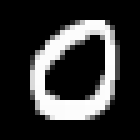

In [4]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

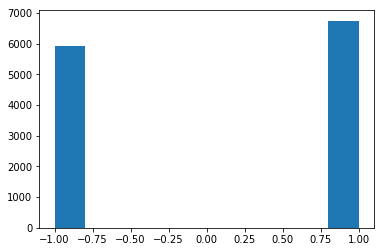

In [5]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

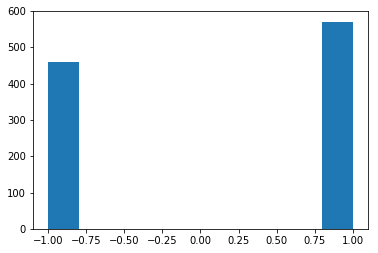

In [6]:
plt.hist(test_labels)

### Split into 10 random disjoint subsets

In [7]:
np.random.seed(0)
N_workers = 10
N_train = 600
print(N_train)
indexes_ = np.random.choice(N_train, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

600


In [8]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

## Define connectivity
To implement the two-star graph, we use a binary connectivity matrix, just to see which nodes are directly connected:

$$  A = 
\begin{bmatrix} 
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1
\end{bmatrix}  $$

In [9]:
A = np.identity(10, dtype='int8')
A[4,0:6] = 1
A[5,4:10] = 1
A[0:5,4] = 1
A[5:10,5] = 1
print(A)
A = A.astype('bool')


[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 1]]


## Compute Gradient of hinge loss

In [10]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

## Compute hingeloss

In [11]:
def hinge_loss(w, X, Y):
#     set_trace()
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1. - Y * (X @ w) # (N,1)
#     set_trace()
    L[L < 0] = 0.
    return L

## Cost

In [12]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

## Predict

In [13]:
def predict(w, X):
    return np.sign(X @ w)

## Accuracy

In [14]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

## Average over neighbors

In [16]:
def average_neighbors(W, A, quantizer, K):
    # return an average of the weights between the neighbors
    # the return is of shape W.shape
    (d,N_neighs) = W.shape
    for i in range(N_neighs):
        Ai = np.copy(A[i,:])
#         set_trace()
        degree_i = np.sum(Ai)
        w_self = W[:,[i]]
        Ai[i] = 0
        w_neighbors = W[:,Ai]
#         set_trace()
        for i in range(degree_i-1):
            w_neighbors[:,[i]] = quantize(w_neighbors[:,[i]], K, quantizer)
        w_bar = (1/degree_i) * (w_self + np.sum(w_neighbors, axis=1, keepdims=True))
        
        assert w_bar.shape == (d, 1)
        
        W[:,[i]] = w_bar
        
    return W

# def average_neighbors(W, A, noise_std, p_val):
#     # return an average of the weights between the neighbors
#     # the return is of shape W.shape
#     (d,N_neighs) = W.shape
#     for i in range(N_neighs):
#         Ai = A[i,:]
#         degree_i = np.sum(Ai)
# #         set_trace()
#         w_bar = np.sum(W[:, Ai], axis=1, keepdims=1) 
#         for n in range(degree_i - 1):
#             w_bar += np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
#         assert w_bar.shape == (d, 1)
#         W[:,[i]] = w_bar/degree_i
#     return W

## Compute z minus mu for a specific node

In [17]:
def compute_z_minus_mu(worker_i, Z, M, A):
    edge_idxs = np.where(A[worker_i,:] == 1)[0]
    # remove self from edge_idxs
    edge_idxs = edge_idxs[np.where(edge_idxs != worker_i)]
    
    summator = 0
    for e in edge_idxs:
        summator += (Z[:, [e], worker_i] - M[:, [e], worker_i])
    
    return summator

## Quantization

In [18]:
range_q2 = np.arange(-7,8+1)
def quantize(v, K, q="Q1"):
    if (q == "Q1"):
#         """ Set K values in v to zero """
        d, m = v.shape
        assert m == 1
        if K >= d:
            return np.zeros((d,1)) # this is 10x slower than  having a global variable for a zero vector
        else:
            idx_to_set_zero = np.random.choice(d, size=(K,1), replace=False) # this seems slow!
            v[idx_to_set_zero] = 0
            return v
        
    if (q == "Q1_1"):
#         """ Set K values in v to zero """
        d, m = v.shape
        assert m == 1
        if K >= d:
            return np.zeros((d,1)) # this is 10x slower than  having a global variable for a zero vector
        else:
            number_of_zeros = np.sum(v == 0)
            k = np.max((0, K-number_of_zeros))
            if k > 0:
                idx_to_set_zero = np.random.choice(d, size=(k,1), replace=False) # this seems slow!
                v[idx_to_set_zero] = 0
            return v
        
    if (q == "Q2"):
#         """ Change type from float64 to int8 """
#         d, m = v.shape
#         assert m == 1
#         return v.astype('int8')
        d, m = v.shape
        assert m == 1
        R = K*range_q2
#         set_trace()
        for i in range(d):
            vi = v[i]
            if vi > R[-1]:
                v[i] = R[-1]
            elif vi < R[0]:
                v[i] = R[0]
            else:
                b_ = (vi > R)
                k = np.max(np.where(b_)) - 7
                prob_k = 1 - (vi - k*K)/K
                if (np.random.rand() < prob_k):
                    v[i] = k*K
                else:
                    v[i] = (k+1)*K
        return v

## Def solver

In [70]:
def solver(X, Y, X_test, Y_test, A, W, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM",
           quantizer="Q1", K=1, mem=False, return_acc=False, verbose=True, seed=-1):
 
    N_workers = len(X)
    dw = W.shape[0]
    assert W.shape[1] == N_workers
    
    if seed != -1:
        np.random.seed(seed)
    
    acc_ = np.zeros(num_iters+1)
#     cost_index = 9
    if return_acc:
        acc_[0] = accuracy(W[:,[0]], X_test, Y_test)
    
#     set_trace()
    if (optimizer == "DSGM"): # decentralized subgradient method
        for i in range(num_iters):
            W = average_neighbors(W, A, quantizer, K)
            for worker_i in range(N_workers):
#                 set_trace()
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)
                W[:,[worker_i]] = w - alpha * g
                
            if return_acc:
                c = 0
                for worker_i in range(N_workers):
                    c += accuracy(W[:,[worker_i]], X_test, Y_test)
                acc_[i+1] = c/N_workers
                
        if (verbose):
            print("DSGM: Number of iterations: ", num_iters, "/", num_iters)
    
    if (optimizer == "ADMM"):

        # set up matrix Z to contain all auxiliary edge variables
        # set up matrix M to contain all dual variables mu

        dz = dw
        Z = np.zeros(shape=(dz,N_workers,N_workers))
        M = np.zeros(shape=(dz,N_workers,N_workers))

        # compute degrees = number of neighbors excluding itself
        degs = np.sum(A,axis=1) - 1

        for i in range(num_iters):
            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)

                sum_z_minus_mu = compute_z_minus_mu(worker_i, Z, M, A)
                W[:,[worker_i]] = (1/(rho*degs[worker_i])) * (rho*sum_z_minus_mu - g)

            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                # loop over neighbors
                edges = np.where(A[worker_i,:] == 1)[0]
                for e in edges:
                    if e != worker_i:
                        """
                            M[:, [e], worker_i] is the mu from worker_i to neighbor e 
                            Z[:, [e], worker_i] is the  z from worker_i to neighbor e
                            M[:, [worker_i], e] is the mu from neighbor e to worker_i and 
                                this a transmission to be quantized
                            W[:,[e]] is sent to all neighbors and must be quantized
                        """
                        mu_sent = quantize(M[:, [worker_i], e], K, quantizer)
                        w_sent = quantize(W[:,[e]], K, quantizer)
                        Z[:, [e], worker_i] = (1/2) * (w + w_sent + (1/rho)*(M[:, [e], worker_i] + mu_sent))

            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                edges = np.where(A[worker_i,:] == 1)[0]
                for e in edges:
                    if e != worker_i:
                        M[:, [e], worker_i] = M[:, [e], worker_i] + rho*(w - Z[:, [e], worker_i])
            
            if return_acc:
                c = 0
                for worker_i in range(N_workers):
                    c += accuracy(W[:,[worker_i]], X_test, Y_test)
                acc_[i+1] = c/N_workers

        if (verbose):
            print("ADMM: Number of iterations: ", num_iters, "/", num_iters)
            print("ADMM: final norm: ", np.linalg.norm(g))
    
    return acc_, W

# Run SVM solver on data

## DSGM Q1

In [86]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0
alpha = 5
num_iters = 1000
lambda_ = 0
epsilon = 0
time1 = time.time()

acc_dsgm, w_out_dsgm_q1 = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM", 
                        quantizer="Q1", K=28**2, mem=False, return_acc=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime DSGM num_iters=", num_iters, ":", time2-time1)

DSGM: Number of iterations:  1000 / 1000
Runtime DSGM num_iters= 1000 : 10.58280348777771


final acc DSGM 0.9921435499515032
Number of correct: 1022 of 1031


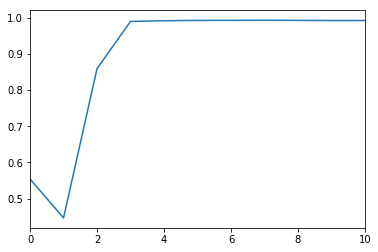

In [87]:
plt.plot(acc_dsgm)
print("final acc DSGM", acc_dsgm[-1])
plt.xlim(0,10)
print("Number of correct:", int(acc_dsgm[-1]*N_test), "of", N_test)
# w_dsgm

## DSGM Q2

In [147]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0
alpha = 5
num_iters = 100
lambda_ = 0
epsilon = 0
time1 = time.time()

acc_dsgm_q2, w_out_dsgm_q2 = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM", 
                        quantizer="Q2", K=100, mem=False, return_acc=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime DSGM num_iters=", num_iters, ":", time2-time1)

DSGM: Number of iterations:  100 / 100
Runtime DSGM num_iters= 100 : 54.987085580825806


final acc DSGM 0.982929194956353
Number of correct: 1013 of 1031
1000*c1 1.366133494299562


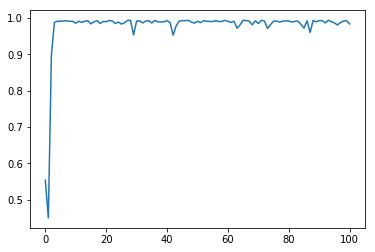

In [148]:
plt.plot(acc_dsgm_q2)
print("final acc DSGM", acc_dsgm_q2[-1])

# plt.yscale('log')
# plt.ylim(.975,1)

N_test = X_test.shape[0]
print("Number of correct:", int(acc_dsgm_q2[-1]*N_test), "of", N_test)
c1 = (1/9)*(np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[1]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[2]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[3]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[4]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[5]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[6]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[7]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[8]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[9]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2))
print("1000*c1",c1*1000)

## ADMM Q1
In general, ADMM seems to get better consensus than DSGM.

In [133]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0.0001 # for ADMM
num_iters = 100
lambda_ = 0
epsilon = 0
time1 = time.time()

cost_admm_q1, w_out_admm_q1 = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "ADMM", 
                        quantizer="Q1", K=784, mem=False, return_acc=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime ADMM num_iters=", num_iters, ":", time2-time1)

ADMM: Number of iterations:  100 / 100
ADMM: final norm:  0.0
Runtime ADMM num_iters= 100 : 1.4192039966583252


final cost ADMM 0.9896217264791465
Number of correct: 1020 of 1031
1000*c1 0.27585943570714483


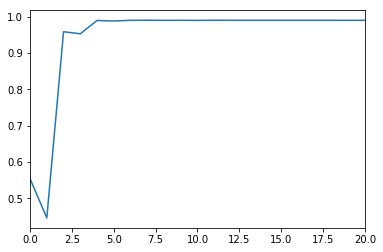

In [134]:
plt.plot(cost_admm_q1)
print("final cost ADMM", cost_admm_q1[-1])
# plt.yscale('log')
# plt.ylim(.975, 1)
plt.xlim(0,20)

N_test = X_test.shape[0]
print("Number of correct:", int(cost_admm_q1[-1]*N_test), "of", N_test)

c1 = (1/9)*(np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[1]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[2]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[3]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[4]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[5]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[6]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[7]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[8]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2)+np.mean((w_out_admm_q1[:,[0]]-w_out_admm_q1[:,[9]])**2/np.linalg.norm(w_out_admm_q1[:,0])**2))
print("1000*c1", 1000*c1)

## ADMM Q2
The implementation of Q2 is a bit slow, so doing it over all the mu-vectors in every iteration makes the simulations very slow.

In [169]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0.0001 # for ADMM
num_iters = 100
lambda_ = 0
epsilon = 0
gamma = 0.001

time1 = time.time()

cost_admm_q2, w_out_admm_q2 = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "ADMM", 
                        quantizer="Q2", K=gamma, mem=False, return_acc=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime ADMM num_iters=", num_iters, ":", time2-time1)

ADMM: Number of iterations:  100 / 100
ADMM: final norm:  0.0
Runtime ADMM num_iters= 100 : 76.30913281440735


final cost ADMM 0.990591658583899
final acc: 0.9932104752667313
Number of correct: 1024.0 of 1031
1000*c1 0.2663956481788206


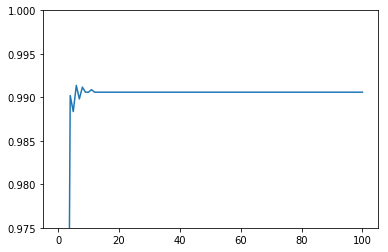

In [170]:
plt.plot(cost_admm_q2)
print("final cost ADMM", cost_admm_q2[-1])
# plt.yscale('log')
plt.ylim(.975, 1)


N_test = X_test.shape[0]
w_admm_q2 = np.mean(w_out_admm_q2, axis=1, keepdims=1)
acc_final = accuracy(w_admm_q2, X_test, y_test)
print("final acc:", acc_final)
print("Number of correct:", acc_final*N_test, "of", N_test)

c1 = (1/9)*(
np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[1]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[2]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[3]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[4]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[5]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[6]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[7]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[8]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2)+np.mean((w_out_admm_q2[:,[0]]-w_out_admm_q2[:,[9]])**2/np.linalg.norm(w_out_admm_q2[:,0])**2))
print("1000*c1",c1*1000)

In [88]:
c1 = (1/9)*(
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[1]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[2]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[3]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[4]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[5]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[6]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[7]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[8]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2)+
np.mean((w_out_dsgm_q1[:,[0]]-w_out_dsgm_q1[:,[9]])**2/np.linalg.norm(w_out_dsgm_q1[:,0])**2))
print("1000*c1",c1*1000)

1000*c1 2.3991570038339582


In [43]:
c1 = (1/9)*(
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[1]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[2]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[3]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[4]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[5]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[6]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[7]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[8]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2)+
np.mean((w_out_dsgm_q2[:,[0]]-w_out_dsgm_q2[:,[9]])**2/np.linalg.norm(w_out_dsgm_q2[:,0])**2))
print("1000*c1",c1*1000)

1000*c1 0.4308191533446648


In [33]:
plt.plot(w_out_dsgm[:,1])
plt.plot(w_out_dsgm[:,2])
plt.plot(w_out_dsgm[:,3])

NameError: name 'w_out_dsgm' is not defined